# A file to visualise phantoms we created

In [29]:
import matplotlib.pyplot as plt
import numpy as np


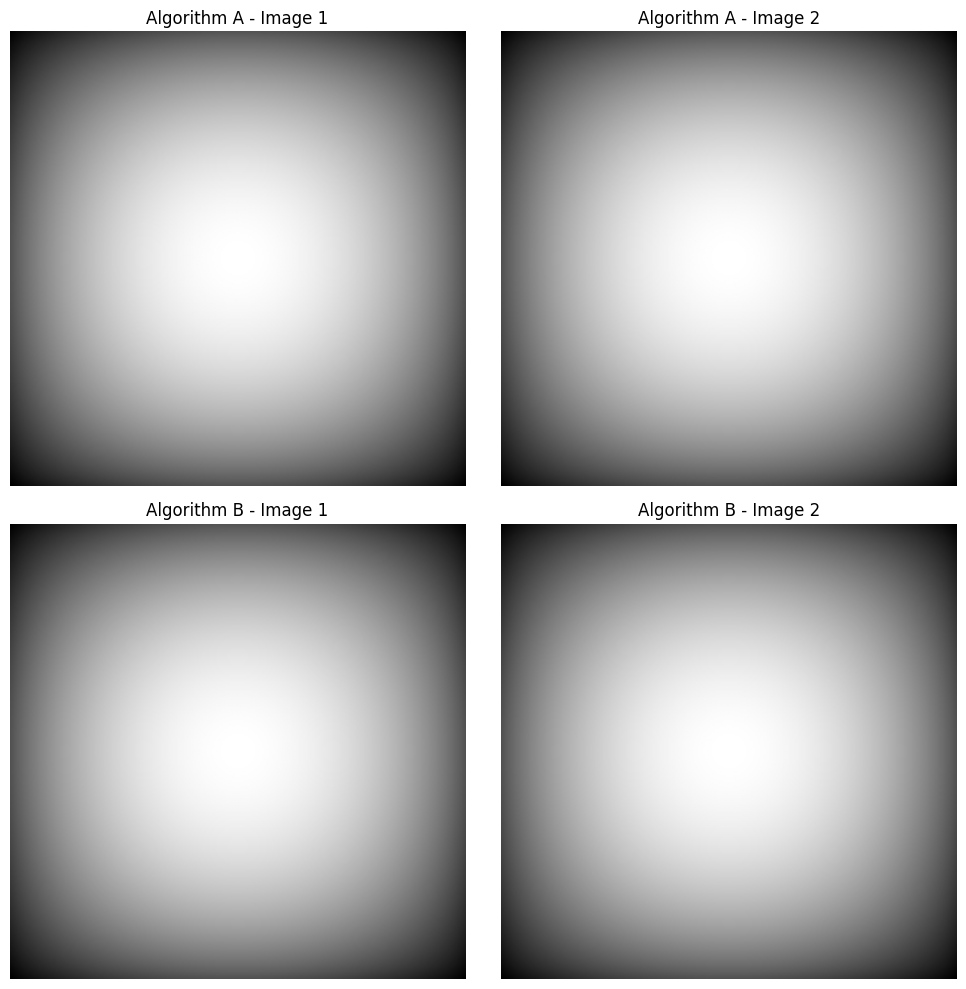

In [30]:
images_A = np.load('data/full_images_algoA.npy', allow_pickle=True)
images_B = np.load('data/full_images_algoB.npy', allow_pickle=True)



# Plotting the images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(images_A[0][0,0,:,:], cmap='gray')
axs[0, 0].set_title('Algorithm A - Image 1')
axs[0, 1].imshow(images_A[1][0,0,:,:], cmap='gray')
axs[0, 1].set_title('Algorithm A - Image 2')
axs[1, 0].imshow(images_B[0][0,0,:,:], cmap='gray')
axs[1, 0].set_title('Algorithm B - Image 1')
axs[1, 1].imshow(images_B[1][0,0,:,:], cmap='gray')
axs[1, 1].set_title('Algorithm B - Image 2')
for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

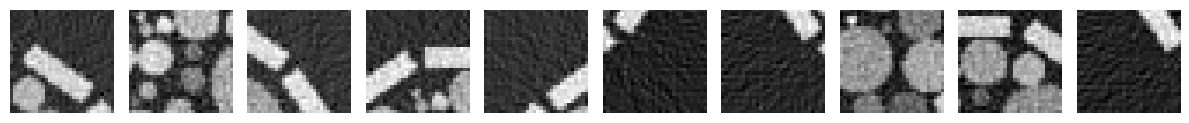

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils import extract_random_patches

# Example with one image
img = images_A[0][0,0,:,:]  # use your own image here (e.g., A[0])
patches = extract_random_patches(img, patch_size=30, num_patches=10)

# Show the result
fig, axs = plt.subplots(1, len(patches), figsize=(12, 3))
for i, patch in enumerate(patches):
    axs[i].imshow(patch, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()


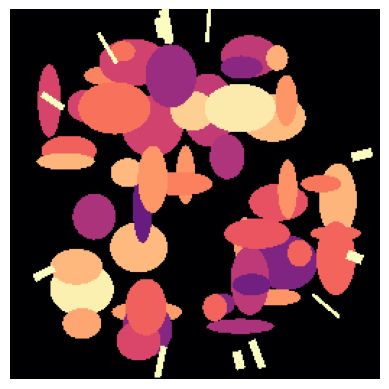

In [12]:
import numpy as np
from skimage.draw import ellipse, polygon
from skimage.io import imsave
import matplotlib.pyplot as plt

def random_phantom(sz=256, n_ellipses=50, n_rects=12):
    """Return a single phantom of shape (sz, sz)."""
    img   = np.zeros((sz, sz), np.float32)
    cx, cy = sz / 2, sz / 2
    radius = sz * 0.45                     # stays well inside borders

    # --- random ellipses -----------------------------------------------
    for _ in range(n_ellipses):
        ry, rx = np.random.uniform(0.02*sz, 0.10*sz, 2)
        dx, dy = np.random.uniform(-radius+rx, radius-rx), np.random.uniform(-radius+ry, radius-ry)
        rr, cc = ellipse(cy+dy, cx+dx, ry, rx, shape=img.shape)
        img[rr, cc] = np.random.uniform(0.3, 1.0)

    # --- rectangles on a ring ------------------------------------------
    for _ in range(n_rects):
        w, h   = np.random.uniform(0.04*sz, 0.10*sz), np.random.uniform(0.01*sz, 0.03*sz)
        theta  = np.random.uniform(0, 2*np.pi)
        px, py = cx + (radius+3)*np.cos(theta), cy + (radius+3)*np.sin(theta)
        # rectangle corners (axis-aligned), then rotate
        box    = np.array([[-w/2,-h/2],[ w/2,-h/2],[ w/2, h/2],[-w/2, h/2]])
        rot    = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
        corners = (box @ rot.T) + np.array([px,py])
        rr, cc  = polygon(corners[:,1], corners[:,0], img.shape)
        img[rr, cc] = 1.0
    return img

# -------- create & optionally save a batch -----------------------------
N        = 100                     # how many phantoms you want
phantoms = [random_phantom() for _ in range(N)]



# quick visual sanity-check
plt.imshow(phantoms[0], cmap='magma'); plt.axis('off'); plt.show()


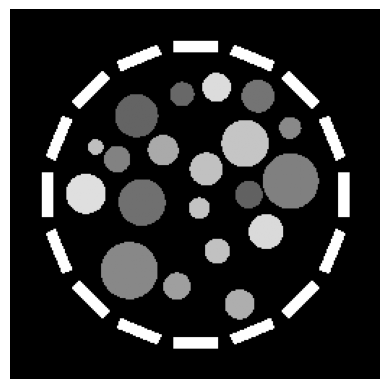

In [28]:
import numpy as np
from skimage.draw import disk, polygon

def make_phantom(sz=256,
                 n_disks=20,
                 n_segments=16,
                 r_core=0.36,      # inner-disk radius  (fraction of sz)
                 r_ring=0.4,       # ring-segment radius
                 seg_len=0.12,     # segment length     (fraction of sz)
                 seg_w=0.03,       # segment width      (fraction of sz)
                 seed=None):
    """
    Square phantom (float32):
      • random disks within a central circle (radius = r_core*sz)
      • n_segments rectangular bars on a larger ring (radius = r_ring*sz)
    Intensities: background=0, disks∈[0.3,0.9], ring=1.0
    """
    rng  = np.random.default_rng(seed)
    img  = np.zeros((sz, sz), np.float32)
    cx   = cy = sz / 2
    R0   = r_core*sz
    R1   = r_ring*sz

    # ---- disks --------------------------------------------------------
    centers = []                         # keep (x, y, radius) of accepted disks
    for _ in range(n_disks):
        rad = rng.uniform(0.02*sz, 0.08*sz)
        for _ in range(1000):          # try up to 1000 times
            dx, dy = rng.uniform(-R0+rad, R0-rad, 2)
            if dx*dx + dy*dy > (R0-rad)**2:   # outside core → reject
                continue
            # overlap-test
            if all((dx-xc)**2 + (dy-yc)**2 >= (rad+rc)**2
                for xc, yc, rc in centers):
                centers.append((dx, dy, rad))
                rr, cc = disk((cy+dy, cx+dx), rad, shape=img.shape)
                img[rr, cc] = rng.uniform(0.3, 0.9)
                break                     # go to next disk


    # ---- ring segments -----------------------------------------------
    hl, hw = seg_len*sz/2, seg_w*sz/2
    rect   = np.array([[-hl,-hw],[hl,-hw],[hl,hw],[-hl,hw]])     # axis-aligned

    for k in range(n_segments):
        theta = 2*np.pi*k / n_segments                 # ← rotate bars
        c, s  = np.cos(theta), np.sin(theta)
        R     = np.array([[-s,c],[c,s]])
        center = np.array([cx + R1*c, cy + R1*s])
        verts  = rect @ R.T + center
        rr, cc = polygon(verts[:,1], verts[:,0], img.shape)
        img[rr, cc] = 1.0

    return img


N        = 100                     # how many phantoms you want
phantoms = [make_phantom() for _ in range(N)]



# quick visual sanity-check
plt.imshow(phantoms[0], cmap='gray'); plt.axis('off'); plt.show()